# Bespoke training loop using GAN on Celeb Dataset


SuperDuperDB supports a wide variety of learning tasks out of the box, using:

- `collection.create_imputation`
- `collection.create_semantic_index`

This allows users to get going quickly training custom models with their database.

In some cases, the learning problem may not fit the cases supported by SuperDuperDB. For this, one can add one's own custom trainer class. To demonstrate this, we show you how to train a GAN to generate celebrity faces together with the database.

You can get the data [here](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np

from superduperdb.training.trainer import Trainer
from superduperdb.mongodb.client import SuperDuperClient

We instatiate a new collection for this task. Each training image will occupy it's own record in MongoDB:

In [ ]:
c = SuperDuperClient()
docs = c.celebs.documents

In order to speed up data injestion, we see the number of download workers:

In [ ]:
docs.database['_meta'].insert_one({'key': 'n_download_workers', 'value': 10})

Inserting data creates an asynchronous job which inserts the images referred to below into the database

In [ ]:
data = [
    {'img': {'_content': {'url': f'file://notebooks/data/img_align_celeba/{x}', 'type': 'image'}}}
    for x in os.listdir('data/img_align_celeba/')
]
docs.remote = True
_, jobs = docs.insert_many(data)
docs.database.watch_job(jobs['_download_content'][0])

We can watch this job like this:

In [ ]:
docs.database.watch_job(jobs['_download_content'][0])

In order to be able to load these images, and also potentially tensors from the database, we need to define 2 custom data types:

In [8]:
import io
import PIL.Image
import PIL.JpegImagePlugin
import PIL.PngImagePlugin


class Image:
    types = (PIL.JpegImagePlugin.JpegImageFile, PIL.Image.Image,
             PIL.PngImagePlugin.PngImageFile)

    @staticmethod
    def encode(x):
        buffer = io.BytesIO()
        x.save(buffer, format='png')
        return buffer.getvalue()

    @staticmethod
    def decode(bytes_):
        return PIL.Image.open(io.BytesIO(bytes_))
    
    
class FloatTensor:
    types = (torch.FloatTensor, torch.Tensor)

    @staticmethod
    def encode(x):
        x = x.numpy()
        assert x.dtype == numpy.float32
        return memoryview(x).tobytes()

    @staticmethod
    def decode(bytes_):
        array = numpy.frombuffer(bytes_, dtype=numpy.float32)
        return torch.from_numpy(array).type(torch.float)


docs.create_type('image', Image(), serializer='dill')
docs.create_type('float_tensor', FloatTensor(), serializer='dill')

Now we're ready to define the generator and discriminator models. As in other examples, where relevant we 
set up pre- and post-processing where the models need to interface with the database:

In [ ]:
import PIL.Image
import numpy


class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def preprocess(self, r=None):
        if not isinstance(r, torch.Tensor):
            r = torch.rand(self.nz, 1, 1)
        return r
        
    def forward(self, input):
        return self.main(input)
    
    def postprocess(self, image_tensor):
        return transforms.ToPILImage()(image_tensor)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ndf = ndf
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def preprocess(self, image):
        return transforms.Compose([
            transforms.Resize(self.ndf),
            transforms.CenterCrop(self.ndf),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])(image)

    def forward(self, input):
        out = self.main(input)
        return out[:, 0, 0, 0]

We use `dill` serialization, since the models are defined inside this notebook:

In [ ]:
generator = Generator()
discriminator = Discriminator()
docs.create_model('generator', generator, serializer='dill')
docs.create_model('discriminator', discriminator, serializer='dill')

Here is our custom trainer object. Inside our trainer, we're free to write sample model outputs to the database, 
and also to redefine any of the standard methods in `superduperdb.training.trainer.Trainer`. 

The main functionality occurs in `.train`, which we redefine here:

In [ ]:
class GANTrainer(Trainer):
    def create_samples(self):
        noise = torch.randn(8, self.models[0].nz, 1, 1)
        images = []
        import tqdm
        with torch.no_grad():
            for i in tqdm.tqdm(range(8)):
                images.append(self.database.apply_model(self.models[0], None))
        self.database.infer_types
        info = self.database.get_object_info(self.train_name, 'learning_task')
        encoder = self.database.types['image']
        info['train_samples'] = [
            {'_content': {'bytes': encoder.encode(i), 'type': 'image'}}
            for i in images
        ]
        self.database['_objects'].replace_one({'_id': info['_id']}, info)
        
    def train(self):
        iterations = 0
        netG, netD = self.models
        device = next(netG.parameters()).device
        optimizerG, optimizerD = self.optimizers
        train_loader = self.data_loaders[0]
        real_label = 1
        fake_label = 0
        criterion = self.objective
        print('')
        it = 0
        epoch = 0
        while True:
            for i, batch in enumerate(train_loader):
                
                if it % self.validation_interval == 0:
                    self.create_samples()
                    self.log_weight_traces()
                    for m, mn in zip(self.models, self.model_names):
                        self.save(mn, m)
                noise, batch = batch
                
                batch = batch.to(device)
                iterations += 1
                b_size = batch.shape[0]
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                netD.zero_grad()
                output = netD(batch).view(-1)
                netD.zero_grad()
                errD_real = self.objective(output, label)
                errD_real.backward()
                
                noise = noise.to(device)
                fake = netG.forward(noise)
                label.fill_(fake_label)
                output = netD(fake.detach()).view(-1)
                errD_fake = criterion(output, label)
                errD_fake.backward()
                errD = errD_real + errD_fake
                optimizerD.step()
                
                netG.zero_grad()
                label.fill_(real_label)
                output = netD(fake).view(-1)
                errG = self.objective(output, label)
                errG.backward()
                optimizerG.step()
                print(f'Epoch {epoch}; Iteration ({i}/ {len(train_loader)}); errD: {errD}; errG; {errG};\r', end='')
                    
                it += 1

            epoch += 1
            if self.n_epochs is not None and epoch >= self.n_epochs:
                return
            
docs.create_trainer('gan_trainer', GANTrainer, serializer='dill')


Now we're ready to do the training. The following command starts the trainer on one of the worker nodes.
We can watch the job output with the `watch_job` command:

In [ ]:
jobs = docs.create_learning_task(
    'face_generation',
    'gan_trainer',
    'gan',
    ['generator', 'discriminator'],
    ['_base', 'img'],
    objective='bce',
    trainer_kwargs={'batch_size': 100, 'validation_interval': 100, 'log_weights': True},
)

In [ ]:
docs.watch_job(jobs[0])

We can also inspect the example outputs created during the training process here:

In [ ]:
from IPython.display import display
for im in docs.database.get_object_info('face_generation', 'learning_task', decode_types=True)['train_samples']:
    display(im)

The model is served on the model server by default:

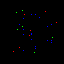

In [9]:
docs.apply_model('generator', torch.randn(100, 1, 1))